In [1]:
import numpy as np
from qiskit import QuantumCircuit
#from qiskit_aer import Aer
#from qiskit import transpile
from qiskit.visualization import *

from qiskit.providers.basic_provider import BasicProvider
from qiskit.primitives import BackendSampler
from qiskit.providers.basic_provider import BasicSimulator

# MPS
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

In [2]:
# cccnot定義
def cccnot(circuit, c1, c2, c3, target):
    # circuit.toffoli(c1, c2, 0)              # qiskit0.43ではQuantumCircuit内に機能があった。
    # circuit.toffoli(c3, 0, target)          # QuantumCircuit.toffoli, instead use QuantumCircuit.ccx(),
    # circuit.toffoli(c1, c2, 0)
    circuit.ccx(c1, c2, 0)                    # qiskit1.0ではcircuitname.ccxで代替
    circuit.ccx(c3, 0, target)                # QuantumCircuit.toffoli, instead use QuantumCircuit.ccx(),
    circuit.ccx(c1, c2, 0)
    #print("enter cccnot")

def add_rule(circuit, n, timestep, position, rules):
    for rule in rules:                                         # ルール全体変数中の[ttf],[fff]等の3セル組の各ルール一つ取り出して回す。
        if position == 0: # Cell is on the left edge
            if rule[0]:                                        # [t,t,f]とか定義されているかどうかチェック？
                continue
            for i in range(1, 3):                              #中右セルだけ対象に処理
                if not rule[i]:
                    circuit.x(n * timestep + position + i)
            circuit.ccx(
                n * timestep + position + 1,
                n * timestep + position + 2,
                n * (timestep + 1) + position + 1
            )
            for i in range(1, 3):
                if not rule[i]:
                    circuit.x(n * timestep + position + i)
        elif position == n - 1:                                # 右端のセルの操作
            if rule[2]:
                continue
            for i in range(2):
                if not rule[i]:
                    circuit.x(n * timestep + position + i)
            circuit.ccx(
                n * timestep + position,
                n * timestep + position + 1,
                n * (timestep + 1) + position + 1
            )
            for i in range(2):
                if not rule[i]:
                    circuit.x(n * timestep + position + i)
        else:                                                   # 両端以外のセルの操作
            for i in range(3):                  # ルールに合わせてcccnot入れる前にビット反転。TTFなどのルールの1つが取り出されている状態。
                if not rule[i]:                 # CCCNOTゲート突入前にTTT状態で反転させる必要がある。TTTが基本でFビットを反転させる。ブール値をそのまま。
                    circuit.x(n * timestep + position + i)  # 現世代の中セル
            cccnot(
                circuit,
                n * timestep + position,           # 現世代の左セル
                n * timestep + position + 1,       # 現世代の中セル
                n * timestep + position + 2,       # 現世代の右セル
                n * (timestep + 1) + position + 1  # 次世代の中セル
            )
            
            for i in range(3):                             #ルールに合わせてcccnot入れる前にビット反転戻し
                if not rule[i]:
                    circuit.x(n * timestep + position + i)
    
def add_rules(circuit, n, m, rules):
    for i in range(m - 1):
        for j in range(n):
            add_rule(circuit, n, i, j, rules)
    for i in range(0, n * m):
        circuit.measure(i + 1, i)

In [3]:
## パラメータ設定のブロック
## セルのサイズ、初期値、ルールの設定
n = 7    # 1次元セルオートマトンのセルの長さ
m = 8    # timestep回数

cirq1 = QuantumCircuit(n * m + 1, n * m)

#ルール90。有名なカオス
rule90 = [
    [True, True, False],
    [True, False, False],
    [False, True, True],
    [False, False, True]
]

#ルール30。有名なカオス。
rule30 = [
    [True, False, False],
    [False, True, True],
    [False, True, False],
    [False, False, True]
]

#--------------------------------- ルール追加
#---ルール30の場合は、左セル真ん中セル右セルの内部状態が、100,011,010,001の場合、次ステップで1になる。
#---111	110	101	100	011	010	001	000
#---0   0   0   1   1   1   1   0     ← 00011110が10進数で30のため、ルール30と呼ぶ。ルール全体は2^8=256パターン
#    [True,  True,  True ],
#    [True,  True,  False],
#    [True,  False, True ],
#    [True,  False, False],
#    [False, True,  True ],
#    [False, True , False],  
#    [False, False, True ],
#    [False, False, True ]

# 00000000
rule00 = [
]

# 00000001
rule01 = [
    [False, False, False]
]

# 00000010
rule02 = [
    [False, False, True]
]

# 00000011
rule03 = [
    [False, False, False],
    [False, False, True ]
]

# 00010010
rule18 = [
    [True,  False, False],
    [False, False, True]
]

# 01100010
rule62 = [
    [True,  True,  False],
    [True,  False, True ],
    [False, False, True ]
]

# 01011010 左右対称、干渉あり。破壊的。
rule90 = [
    [True,  True,  False],
    [True,  False, False],
    [False, True,  True ],
    [False, False, True ]
]

# ルール110。チューリング完全。古典で大きなマトリクスで動かすとグライダーが出現する。
# 01101110
rule110 = [
    [True,  True,  False],
    [True,  False, True ],
    [False, True , True ],  
    [False, True , False ],  
    [False, False, True ]
]

# 01111010 左右対称、干渉あり。
rule122 = [
#    [True,  True,  True ],
    [True,  True,  False],
    [True,  False, True ],
    [True,  False, False],
    [False, True,  True ],
#    [False, True , False],  
    [False, False, True ]
#    [False, False, True ]
]

# CCCH確認用
# 10000000
rule128 = [
    [True,  True, True]
]

# ルール184。渋滞。素粒子の対消滅に似ているらしい。
# 10111000
rule184 = [
    [True,  True,  True ],
    [True,  False, True ],
    [True,  False, False],  
    [False, True , True ] 
]
#---------------------------------
##
# Configure the starting cells here:
# q4だけ|1>、その他は|0>
cirq1.x(4)

# 重ね合わせ有効化。
# ★最初は重ね合わせ無しで各ルールを実行すると面白い。
# コメントアウトすると全ビットが古典ビットとなり、
# 古典セルオートマトン（決定論的に動き、最後のcountヒストグラムが1パターンしか出ない。）と同じになる。
# Q5をアダマールにして量子状態。
# range(n)で回す。n=7の場合は0,1,2,3,4,5,6まで
# Q0はCCCNOTのancillaなので、除外するため、cirq1.h(i + 1)
# カウンタiが3の時は、さっきXやったばかりのcirq1.x(4)とぶつからないように除外
#cirq1.h(5)
for i in range(n):
    if i != 3:
        cirq1.h(i + 1)

################## h5だけアダマールしたい場合
#cirq1.h(5)

################## ルールを選択
# Add the rules
#add_rules(cirq1, n, m, rule00)  
#add_rules(cirq1, n, m, rule01)  
#add_rules(cirq1, n, m, rule18)    
#add_rules(cirq1, n, m, rule30)  # MIT:Asymmetrical - ???  
#add_rules(cirq1, n, m, rule62)  
#add_rules(cirq1, n, m, rule90)  # MIT:Symmetrical - destructive interference
#add_rules(cirq1, n, m, rule110) 
add_rules(cirq1, n, m, rule122)  # MIT:Symmetrical - constructrive interference
#add_rules(cirq1, n, m, rule128)     
#add_rules(cirq1, n, m, rule184)  
#cirq1.draw("mpl")

Time taken: 1.6390008926391602 sec
{'01000101000001111111111001100111101101101011101001101000': 13, '01010101010101010001010000011111111110011001111011011010': 10, '10011111111011110111001110011001111111101111011100111001': 13, '10101010101010101010101000101000001111111111001100111100': 12, '10000011111111011011010111011110111110001101111101001100': 21, '10101010101010101010101000101000001111111101100110011110': 16, '01000101000001111111101101101011101111001011000010111111': 15, '01010101010101010001010000011111111011001100111100001101': 16, '10111011110111110001101111101011001010111110001101111101': 16, '11110111101110011100110011111111011110111001110011001111': 18, '01010101010101010001010000011111111011001110111100101100': 20, '01010101010101010001010000011111111011001110111100101101': 14, '10101010101010101010101010101010101010101000101000001000': 10, '10101010101010101010101010101010101010001010000011111111': 17, '11111110110110101110111101111100011011111000110010001111': 16, '111

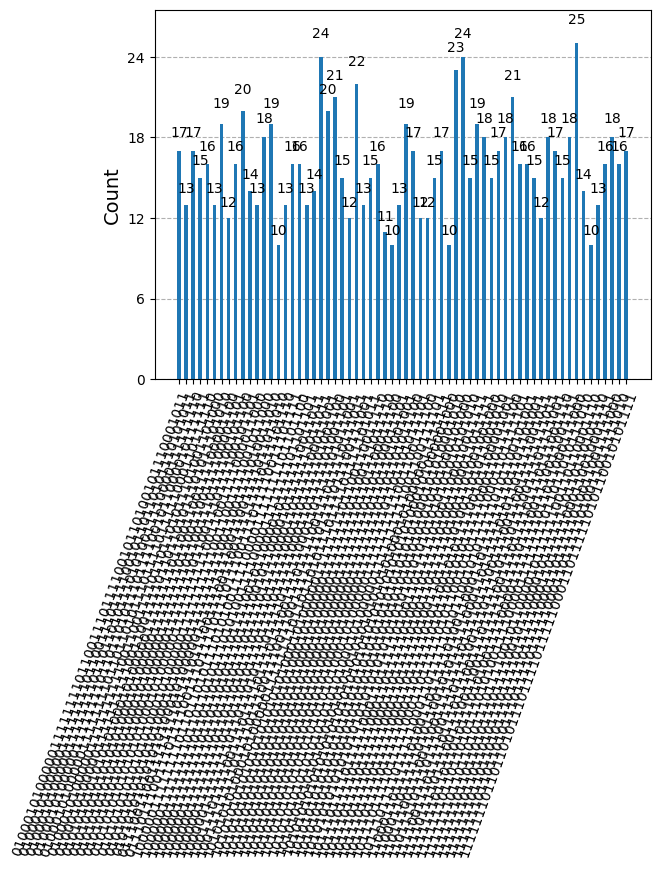

In [4]:
# jobの実行方法はqiskit1.0用（旧aer使用)に入れ替えました。
shots = 1024

# Select the AerSimulator from the Aer provider
simulator = AerSimulator(method='matrix_product_state')
#simulator = AerSimulator(method='stabilizer')
tcirc = transpile(cirq1, simulator)
result = simulator.run(tcirc).result()
print("Time taken: {} sec".format(result.time_taken))
result.get_counts()

counts = result.get_counts(cirq1)
measured_bit = max(counts, key=counts.get)
print(counts)
plot_histogram(counts)
#---

In [5]:
simulator.configuration().n_qubits

63

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
----
[[0.50292969 0.50292969 0.47851562 1.         0.50585938 0.51171875
  0.50195312]
 [0.50292969 0.60449219 0.75878906 0.50585938 0.734375   0.61523438
  0.51171875]
 [0.60449219 0.86816406 0.5390625  0.68554688 0.546875   0.8828125
  0.61523438]
 [0.86816406 0.51171875 0.5703125  0.4921875  0.57617188 0.49414062
  0.8828125 ]
 [0.51171875 0.71972656 0.53710938 0.52539062 0.53027344 0.71679688
  0.49414062]
 [0.71972656 0.59082031 0.65722656 0.38867188 0.64648438 0.58984375
  0.71679688]
 [0.59082031 0.734375   0.60058594 0.49609375 0.60839844 0.74511719
  0.58984375]
 [0.734375   0.48046875 0.5546875  0.51074219 0.546875   0.47363281
  0.74511719]]


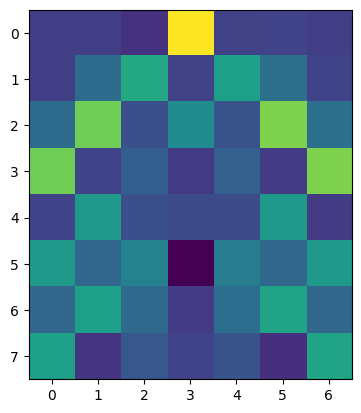

In [6]:
# Matplotlib: データビジュアライゼーションパッケージの全体
# pyplot: matplotlibパッケージ内のモジュール:暗黙的かつ自動的に図形や軸を作成する。
#         とりあえず行列を突っ込むと適当にスケールしていい感じに表示できる。
# Draw everything
import matplotlib.pyplot as plt

grid = np.zeros((m, n))
print(grid)

# 表示用の古典ビットごとに、1が観測された回数/全ショットの割合をセット
for bitstring, cnt in counts.items():
    prob = cnt / shots
    for idx, c in enumerate(reversed(bitstring)):
        if c == '1':
            grid[idx // n, idx % n] += prob

print('----')
print(grid)

# imshowはヒートマップ。行
plt.imshow(grid, interpolation='nearest')  # 
# plt.imshow(grid, interpolation='bilinear') 

In [7]:
import qiskit
qiskit.__version__

'1.1.0'